# Q1

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

df['label'] = df['label'].map({'spam': 1, 'ham': 0})

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

df['text'] = df['text'].apply(preprocess_text)

vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['text']).toarray()
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Class Distribution:")
print(pd.Series(y).value_counts())
print()

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

train_acc = accuracy_score(y_train, stump.predict(X_train))
test_acc = accuracy_score(y_test, stump.predict(X_test))

print("Part B - Decision Stump Baseline")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, stump.predict(X_test)))

T = 15
n_samples = len(X_train)
weights = np.ones(n_samples) / n_samples
alphas = []
classifiers = []
errors = []

for t in range(T):
    clf = DecisionTreeClassifier(max_depth=1, random_state=t)
    clf.fit(X_train, y_train, sample_weight=weights)
    
    y_pred = clf.predict(X_train)
    
    misclassified = (y_pred != y_train)
    error = np.sum(weights[misclassified]) / np.sum(weights)
    
    alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
    
    print(f"\nIteration {t+1}:")
    print(f"Misclassified indices: {np.where(misclassified)[0][:10]}...")
    print(f"Weights of misclassified (first 5): {weights[misclassified][:5]}")
    print(f"Alpha: {alpha:.4f}")
    
    weights[misclassified] *= np.exp(alpha)
    weights[~misclassified] *= np.exp(-alpha)
    weights /= np.sum(weights)
    
    classifiers.append(clf)
    alphas.append(alpha)
    errors.append(error)

def predict_adaboost(X, classifiers, alphas):
    final_pred = np.zeros(len(X))
    for clf, alpha in zip(classifiers, alphas):
        pred = clf.predict(X)
        pred = np.where(pred == 0, -1, 1)
        final_pred += alpha * pred
    return (final_pred >= 0).astype(int)

y_train_pred = predict_adaboost(X_train, classifiers, alphas)
y_test_pred = predict_adaboost(X_test, classifiers, alphas)




Class Distribution:
0    4825
1     747
Name: count, dtype: int64

Part B - Decision Stump Baseline
Train Accuracy: 0.8840
Test Accuracy: 0.8906
Confusion Matrix:
[[923  42]
 [ 80  70]]

Iteration 1:
Misclassified indices: [ 1  6 17 33 34 51 58 71 73 80]...
Weights of misclassified (first 5): [0.00022437 0.00022437 0.00022437 0.00022437 0.00022437]
Alpha: 1.0154

Iteration 2:
Misclassified indices: [ 1  4  6 26 29 38 51 58 71 90]...
Weights of misclassified (first 5): [0.00096712 0.0001269  0.00096712 0.0001269  0.0001269 ]
Alpha: 0.5053

Iteration 3:
Misclassified indices: [ 0  2  3  5  7  8  9 10 11 12]...
Weights of misclassified (first 5): [8.6548258e-05 8.6548258e-05 8.6548258e-05 8.6548258e-05 8.6548258e-05]
Alpha: 0.3069

Iteration 4:
Misclassified indices: [ 1  4  6 26 29 33 38 51 58 71]...
Weights of misclassified (first 5): [0.00139639 0.00018323 0.00139639 0.00018323 0.00033853]
Alpha: 0.2894

Iteration 5:
Misclassified indices: [ 0  2  3  5  7  8  9 10 11 12]...
Weights of 

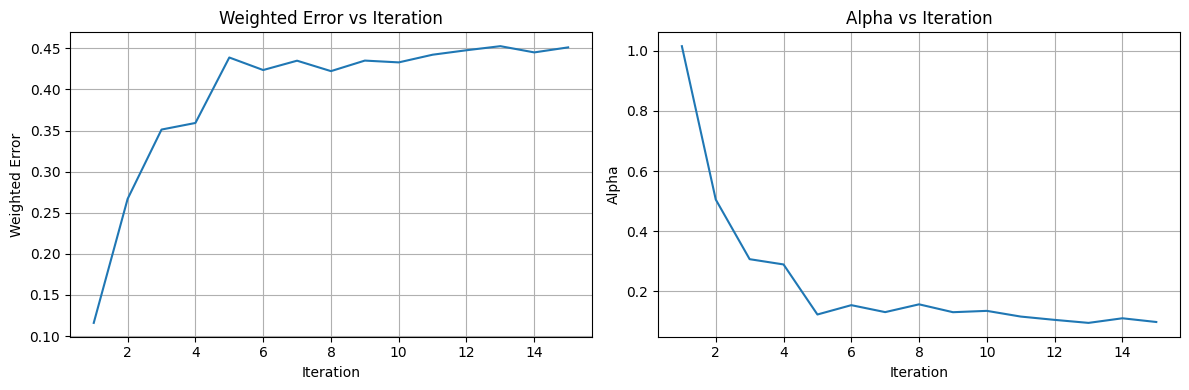

In [38]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, T+1), errors)
plt.xlabel('Iteration')
plt.ylabel('Weighted Error')
plt.title('Weighted Error vs Iteration')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, T+1), alphas)
plt.xlabel('Iteration')
plt.ylabel('Alpha')
plt.title('Alpha vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()

ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42
)
ada_clf.fit(X_train, y_train)

train_acc_sk = accuracy_score(y_train, ada_clf.predict(X_train))
test_acc_sk = accuracy_score(y_test, ada_clf.predict(X_test))



In [39]:
print(f"Train Accuracy: {train_acc_sk:.4f}")
print(f"Test Accuracy: {test_acc_sk:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, ada_clf.predict(X_test)))


Train Accuracy: 0.9168
Test Accuracy: 0.9238
Confusion Matrix:
[[963   2]
 [ 83  67]]


# Q2

Part A - Baseline Model
Training Accuracy: 0.7681
Test Accuracy: 0.6889
Confusion Matrix:
[[38 11]
 [17 24]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73        49
           1       0.69      0.59      0.63        41

    accuracy                           0.69        90
   macro avg       0.69      0.68      0.68        90
weighted avg       0.69      0.69      0.69        90

Part B - AdaBoost Grid Search
n_estimators=5, lr=0.1, accuracy=0.6889
n_estimators=10, lr=0.1, accuracy=0.8778
n_estimators=25, lr=0.1, accuracy=0.8667
n_estimators=50, lr=0.1, accuracy=0.8778
n_estimators=100, lr=0.1, accuracy=0.8667
n_estimators=5, lr=0.5, accuracy=0.8333
n_estimators=10, lr=0.5, accuracy=0.8444
n_estimators=25, lr=0.5, accuracy=0.8556
n_estimators=50, lr=0.5, accuracy=0.8667
n_estimators=100, lr=0.5, accuracy=0.8333
n_estimators=5, lr=1.0, accuracy=0.8778
n_estimators=10, lr=1.0, accuracy=0.8111
n_estimators=25, lr=

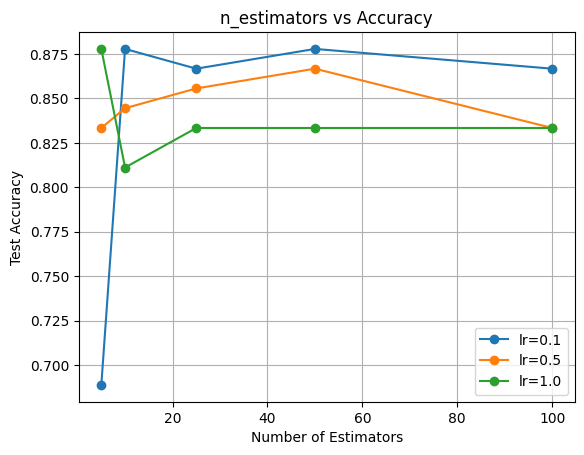


Best Config: n_estimators=10, lr=0.1, acc=0.8778

Part C - Misclassification Pattern


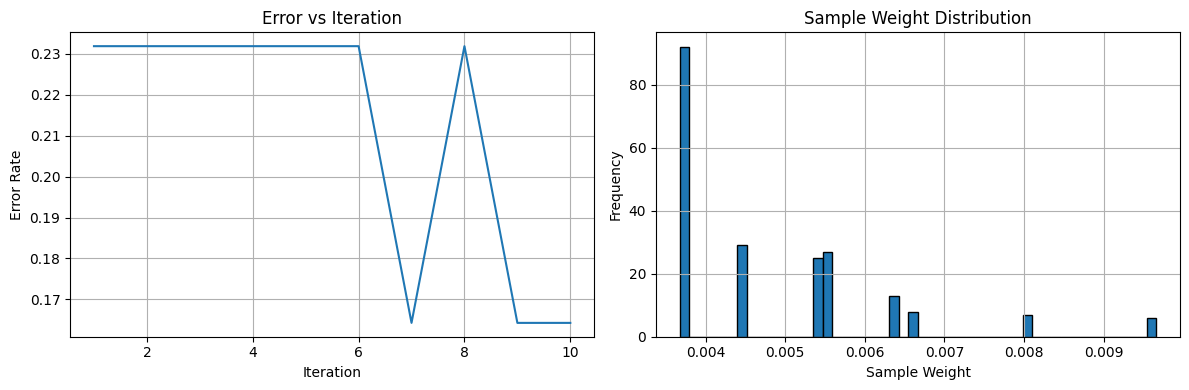

Highest weight samples: [122 167  51  21  86  32   8 108   4 179]
AdaBoost increases weights on hard samples, forcing subsequent learners to focus on them.

Part D - Feature Importance


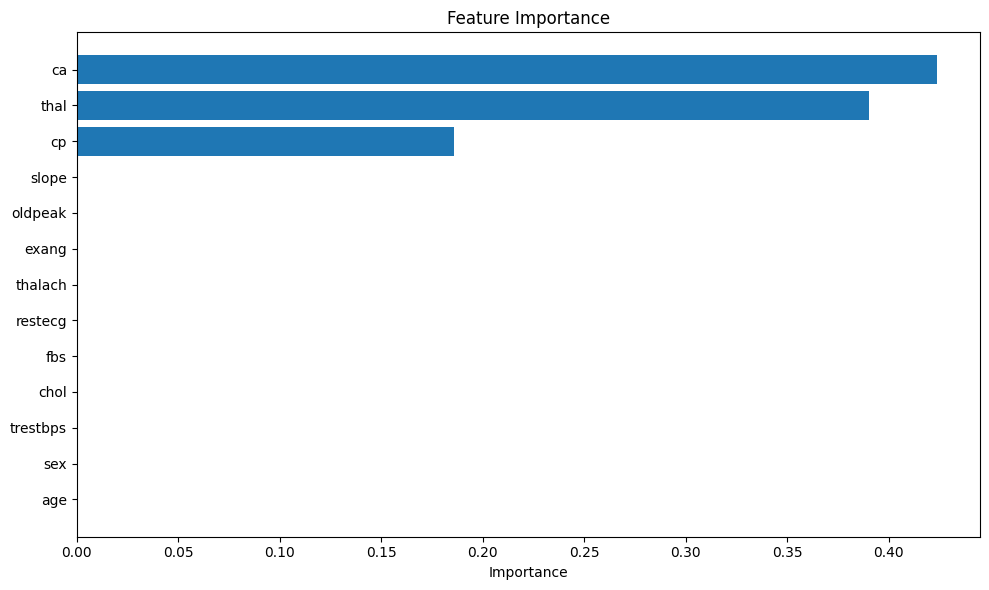

Top 5 Features:
1. ca: 0.4238
2. thal: 0.3904
3. cp: 0.1857
4. slope: 0.0000
5. oldpeak: 0.0000

These features relate to cardiovascular health indicators like chest pain,
heart rate, and cholesterol, which are critical for predicting heart disease.


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
df = pd.read_csv(data_url, names=columns, na_values='?')

df = df.dropna()
df['target'] = (df['target'] > 0).astype(int)

X = df.drop('target', axis=1)
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print("Part A - Baseline Model")
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

train_acc = accuracy_score(y_train, stump.predict(X_train))
test_acc = accuracy_score(y_test, stump.predict(X_test))

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, stump.predict(X_test)))
print("Classification Report:")
print(classification_report(y_test, stump.predict(X_test)))

print("Part B - AdaBoost Grid Search")
n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

results = []

for lr in learning_rates:
    accuracies = []
    for n_est in n_estimators_list:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_est,
            learning_rate=lr,
            random_state=42
        )
        ada.fit(X_train, y_train)
        acc = accuracy_score(y_test, ada.predict(X_test))
        accuracies.append(acc)
        results.append({'n_estimators': n_est, 'learning_rate': lr, 'accuracy': acc})
        print(f"n_estimators={n_est}, lr={lr}, accuracy={acc:.4f}")
    
    plt.plot(n_estimators_list, accuracies, marker='o', label=f'lr={lr}')

plt.xlabel('Number of Estimators')
plt.ylabel('Test Accuracy')
plt.title('n_estimators vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()

results_df = pd.DataFrame(results)
best_config = results_df.loc[results_df['accuracy'].idxmax()]
print(f"\nBest Config: n_estimators={int(best_config['n_estimators'])}, lr={best_config['learning_rate']}, acc={best_config['accuracy']:.4f}\n")

print("Part C - Misclassification Pattern")
best_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=int(best_config['n_estimators']),
    learning_rate=best_config['learning_rate'],
    random_state=42
)
best_ada.fit(X_train, y_train)

staged_errors = []
for y_pred in best_ada.staged_predict(X_train):
    error = 1 - accuracy_score(y_train, y_pred)
    staged_errors.append(error)

sample_weights = np.ones(len(X_train)) / len(X_train)
y_train_arr = y_train.values
for estimator in best_ada.estimators_:
    y_pred = estimator.predict(X_train)
    incorrect = (y_pred != y_train_arr)
    estimator_error = np.sum(sample_weights[incorrect]) / np.sum(sample_weights)
    estimator_weight = best_ada.learning_rate * 0.5 * np.log((1 - estimator_error) / (estimator_error + 1e-10))
    sample_weights[incorrect] *= np.exp(estimator_weight)
    sample_weights[~incorrect] *= np.exp(-estimator_weight)
    sample_weights /= np.sum(sample_weights)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(staged_errors)+1), staged_errors)
plt.xlabel('Iteration')
plt.ylabel('Error Rate')
plt.title('Error vs Iteration')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(sample_weights, bins=50, edgecolor='black')
plt.xlabel('Sample Weight')
plt.ylabel('Frequency')
plt.title('Sample Weight Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()

top_weight_indices = np.argsort(sample_weights)[-10:]
print(f"Highest weight samples: {top_weight_indices}")
print("AdaBoost increases weights on hard samples, forcing subsequent learners to focus on them.\n")

print("Part D - Feature Importance")
feature_importance = best_ada.feature_importances_
feature_names = columns[:-1]

sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx])
plt.yticks(range(len(feature_importance)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 5 Features:")
for i in range(5):
    idx = sorted_idx[i]
    print(f"{i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")

print("\nThese features relate to cardiovascular health indicators like chest pain,")
print("heart rate, and cholesterol, which are critical for predicting heart disease.")

# Q3

In [49]:
file_path = "WISDM_ar_v1.1_raw.txt"

rows = []
with open(file_path) as f:
    for line in f:
        try:
            parts = line.split(',')
            user = parts[0]
            activity = parts[1]
            x = float(parts[3])
            y = float(parts[4])
            z = float(parts[5].split(';')[0])  # remove ;\n
            rows.append([user, activity, x, y, z])
        except:
            continue

df = pd.DataFrame(rows, columns=["user", "activity", "x", "y", "z"])

print("Dataset Loaded:", df.shape)
print(df.head())

vigorous = ["Jogging", "Upstairs"]
df["label"] = df["activity"].apply(lambda a: 1 if a in vigorous else 0)

X = df[["x", "y", "z"]].values
y = df["label"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


Dataset Loaded: (1098203, 5)
  user activity         x          y         z
0   33  Jogging -0.694638  12.680544  0.503953
1   33  Jogging  5.012288  11.264028  0.953424
2   33  Jogging  4.903325  10.882658 -0.081722
3   33  Jogging -0.612916  18.496431  3.023717
4   33  Jogging -1.184970  12.108489  7.205164


In [50]:
# part B 
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

pred_train = stump.predict(X_train)
pred_test = stump.predict(X_test)

print("\n--- PART B: Decision Stump ---")
print("Train Accuracy:", accuracy_score(y_train, pred_train))
print("Test Accuracy:", accuracy_score(y_test, pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_test))



--- PART B: Decision Stump ---
Train Accuracy: 0.6525986611893196
Test Accuracy: 0.6510634035591466
Confusion Matrix:
 [[171929  17581]
 [ 97380  42571]]


In [51]:
# part c 
T = 20
n = len(X_train)
weights = np.ones(n) / n

alphas = []
errors = []

print("\n--- PART C: Manual AdaBoost ---")

for t in range(T):

    stump_t = DecisionTreeClassifier(max_depth=1)
    stump_t.fit(X_train, y_train, sample_weight=weights)

    pred_t = stump_t.predict(X_train)
    misclassified = (pred_t != y_train)

    err_t = np.sum(weights * misclassified)
    err_t = max(err_t, 1e-10)

    alpha_t = 0.5 * np.log((1 - err_t) / err_t)

    weights *= np.exp(alpha_t * misclassified)
    weights /= weights.sum()

    errors.append(err_t)
    alphas.append(alpha_t)

    print(f"Iteration {t+1} — error={err_t:.4f}, alpha={alpha_t:.4f}")

final_train_score = np.zeros(len(y_train))
final_test_score = np.zeros(len(y_test))

for i in range(T):
    stump_i = DecisionTreeClassifier(max_depth=1)
    stump_i.fit(X_train, y_train, sample_weight=weights)

    final_train_score += alphas[i] * stump_i.predict(X_train)
    final_test_score += alphas[i] * stump_i.predict(X_test)

train_pred = (final_train_score > 0).astype(int)
test_pred = (final_test_score > 0).astype(int)

print("\nFinal Manual AdaBoost Train Accuracy:", accuracy_score(y_train, train_pred))
print("Final Manual AdaBoost Test Accuracy:", accuracy_score(y_test, test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred))



--- PART C: Manual AdaBoost ---
Iteration 1 — error=0.3474, alpha=0.3152
Iteration 2 — error=0.4232, alpha=0.1548
Iteration 3 — error=0.4600, alpha=0.0803
Iteration 4 — error=0.4781, alpha=0.0437
Iteration 5 — error=0.4701, alpha=0.0598
Iteration 6 — error=0.4741, alpha=0.0519
Iteration 7 — error=0.4651, alpha=0.0700
Iteration 8 — error=0.4738, alpha=0.0524
Iteration 9 — error=0.4713, alpha=0.0575
Iteration 10 — error=0.4735, alpha=0.0531
Iteration 11 — error=0.4741, alpha=0.0518
Iteration 12 — error=0.4723, alpha=0.0556
Iteration 13 — error=0.4750, alpha=0.0499
Iteration 14 — error=0.4796, alpha=0.0409
Iteration 15 — error=0.4783, alpha=0.0435
Iteration 16 — error=0.4788, alpha=0.0423
Iteration 17 — error=0.4761, alpha=0.0478
Iteration 18 — error=0.4609, alpha=0.0784
Iteration 19 — error=0.4579, alpha=0.0843
Iteration 20 — error=0.4789, alpha=0.0422

Final Manual AdaBoost Train Accuracy: 0.6137637855093127
Final Manual AdaBoost Test Accuracy: 0.6123365132747123
Confusion Matrix:
 [[1

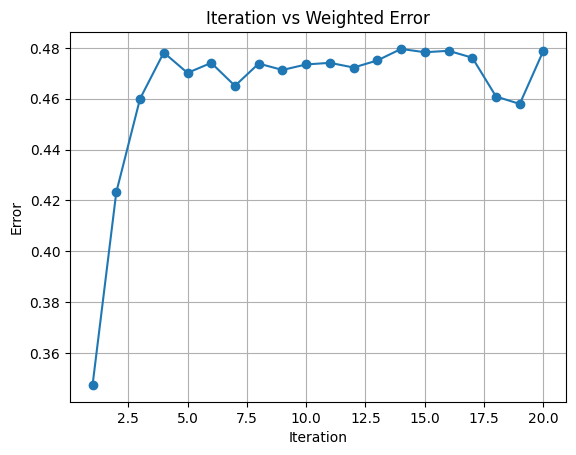

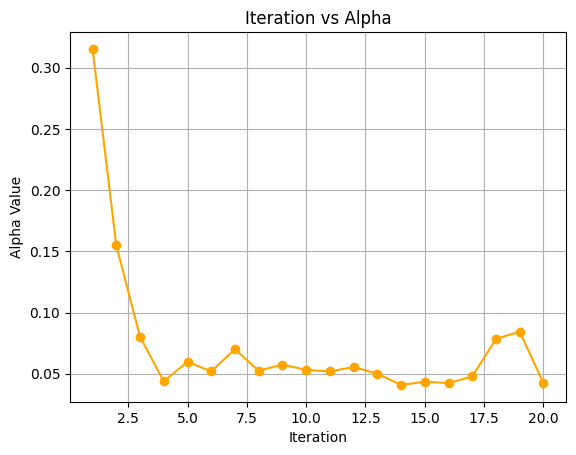

In [52]:
plt.plot(range(1, T+1), errors, marker='o')
plt.title("Iteration vs Weighted Error")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.grid()
plt.show()

plt.plot(range(1, T+1), alphas, marker='o', color='orange')
plt.title("Iteration vs Alpha")
plt.xlabel("Iteration")
plt.ylabel("Alpha Value")
plt.grid()
plt.show()


In [ ]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0
)

ada.fit(X_train, y_train)

train_acc = ada.score(X_train, y_train)
test_acc = ada.score(X_test, y_test)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("Confusion Matrix:\n", confusion_matrix(y_test, ada.predict(X_test)))
